In [8]:
# in order to work with arff files we have to install 'liac-arff' - if first usage: uncomment code cell below and run
# pip install liac-arff

Note: you may need to restart the kernel to use updated packages.


In [36]:
import warnings
warnings.filterwarnings("ignore")

In [94]:
# basic packages
import arff
import numpy as np
import pandas as pd

# packages for plotting
import seaborn as sns
import matplotlib.pyplot as plt

# package for balancing
from imblearn.over_sampling import RandomOverSampler

# packages for preprocessing
from sklearn import preprocessing

# 1) Data Loading & First Insights

In [2]:
# import data
data = arff.load(open('data/diabetes_dataset.arff', 'r'))

In [3]:
df_header = list(pd.DataFrame(data['attributes'])[0])
df_header

['Age',
 'Gender',
 'Family_Diabetes',
 'highBP',
 'PhysicallyActive',
 'BMI',
 'Smoking',
 'Alcohol',
 'Sleep',
 'SoundSleep',
 'RegularMedicine',
 'JunkFood',
 'Stress',
 'BPLevel',
 'Pregancies',
 'Pdiabetes',
 'UriationFreq',
 'Diabetic']

In [57]:
# convert arff data into a pandas dataframe
df = pd.DataFrame(data['data'], columns=df_header)
df.head()

,Age,Gender,Family_Diabetes,highBP,PhysicallyActive,BMI,Smoking,Alcohol,Sleep,SoundSleep,RegularMedicine,JunkFood,Stress,BPLevel,Pregancies,Pdiabetes,UriationFreq,Diabetic
0,50-59,Male,no,yes,one hr or more,39.0,no,no,8,6,no,occasionally,sometimes,high,0.0,0,not much,no
1,50-59,Male,no,yes,less than half an hr,28.0,no,no,8,6,yes,very often,sometimes,normal,0.0,0,not much,no
2,40-49,Male,no,no,one hr or more,24.0,no,no,6,6,no,occasionally,sometimes,normal,0.0,0,not much,no
3,50-59,Male,no,no,one hr or more,23.0,no,no,8,6,no,occasionally,sometimes,normal,0.0,0,not much,no
4,40-49,Male,no,no,less than half an hr,27.0,no,no,8,8,no,occasionally,sometimes,normal,0.0,0,not much,no


In [8]:
# print main information about data
print("There are {} entries with {} columns including the target variable 'Diabetic'.".format(df.shape[0], df.shape[1]))

There are 952 entries with 18 columns including the target variable 'Diabetic'.


In [9]:
# check for missing values
display(df.isnull().sum())
print("There are {} missing values.".format(df.isnull().sum().sum()))

Age                  0
Gender               0
Family_Diabetes      0
highBP               0
PhysicallyActive     0
BMI                  4
Smoking              0
Alcohol              0
Sleep                0
SoundSleep           0
RegularMedicine      0
JunkFood             0
Stress               0
BPLevel              0
Pregancies          42
Pdiabetes            1
UriationFreq         0
Diabetic             1
dtype: int64

There are 48 missing values.


There are a few missing values. Empty answers in pregnancies could be seen as 0 pregnancies. Nonetheless, we are not completely sure about this. Therefore, in order to have better explanation of feature importance in the end and in order to train our models in the best possible way, we discard the entries with missing values. It will change the number of entries only slightly.

In [58]:
# drop rows with missing values
df.dropna(inplace=True)

# again print main information about data
print("There are {} entries with {} columns including the target variable 'Diabetic'.".format(df.shape[0], df.shape[1]))

There are 905 entries with 18 columns including the target variable 'Diabetic'.


In [59]:
# check for duplicates
print("There are {} duplicated entries.".format(df.duplicated().sum()))

There are 622 duplicated entries.


This is somehow expected in this dataset. The data has been achieved by a survey where individual people answered a questionnaire. Because of that, it is usual to see similar or also same entries for different persons. 

In [60]:
# now let's have a closer look at the target data
df['Diabetic'].unique()

array(['no', 'yes', ' no'], dtype=object)

We can see that there are some faulty data in the dataset in regards to our target variable. We have the class label ' no' which is probably due to incorrect recording. We will change these to 'no'.

In [61]:
df.loc[df['Diabetic']==' no', 'Diabetic'] = 'no'

In [62]:
# check if it worked
df['Diabetic'].unique()

array(['no', 'yes'], dtype=object)

In [63]:
# check types of columns and convert them into useful types according to their meaning afterwards
df.dtypes

Age                  object
Gender               object
Family_Diabetes      object
highBP               object
PhysicallyActive     object
BMI                 float64
Smoking              object
Alcohol              object
Sleep                 int64
SoundSleep            int64
RegularMedicine      object
JunkFood             object
Stress               object
BPLevel              object
Pregancies          float64
Pdiabetes            object
UriationFreq         object
Diabetic             object
dtype: object

In general, we have a lot of categorical variables. For most of them this is expected. Nonetheless, for 'Age' we ususally would have expected numerical values but it has already been binned into categories like '40-49'. We will see how useful the bins are for the models later on. Other categorical features like 'Gender' or 'Family_Diabetes' only have two possible labels. We can change them later into numerical ones in our preprocessing. Moreover, there are some numerical values as well such as 'BMI', 'Sleep', or 'Pregnancies'. We'll have a closer look at each of them later for preprocessing. Let's first visualize them before further preprocessing. 

# 2) Data Visualization

In [66]:
# define a distribution graph (histogram/bar graph) for the different columns
def plotDistributions(df, nGraphs, nGraphsPerRow):
    nrows, ncols = df.shape
    nGraphRow = (ncols + nGraphsPerRow - 1) / nGraphsPerRow
    plt.figure(num = None, figsize = (6 * nGraphsPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    
    for i in range(min(ncols, nGraphs)):
        plt.subplot(nGraphRow, nGraphsPerRow, i + 1)
        columnDf = df.iloc[:, i]
        
        # check if type in column in object or number
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)): 
            # do value counts a bar plot for categorical features
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            # do histogram for numerical features
            columnDf.hist()
            
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{df_header[i]} (column {i})')
        
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

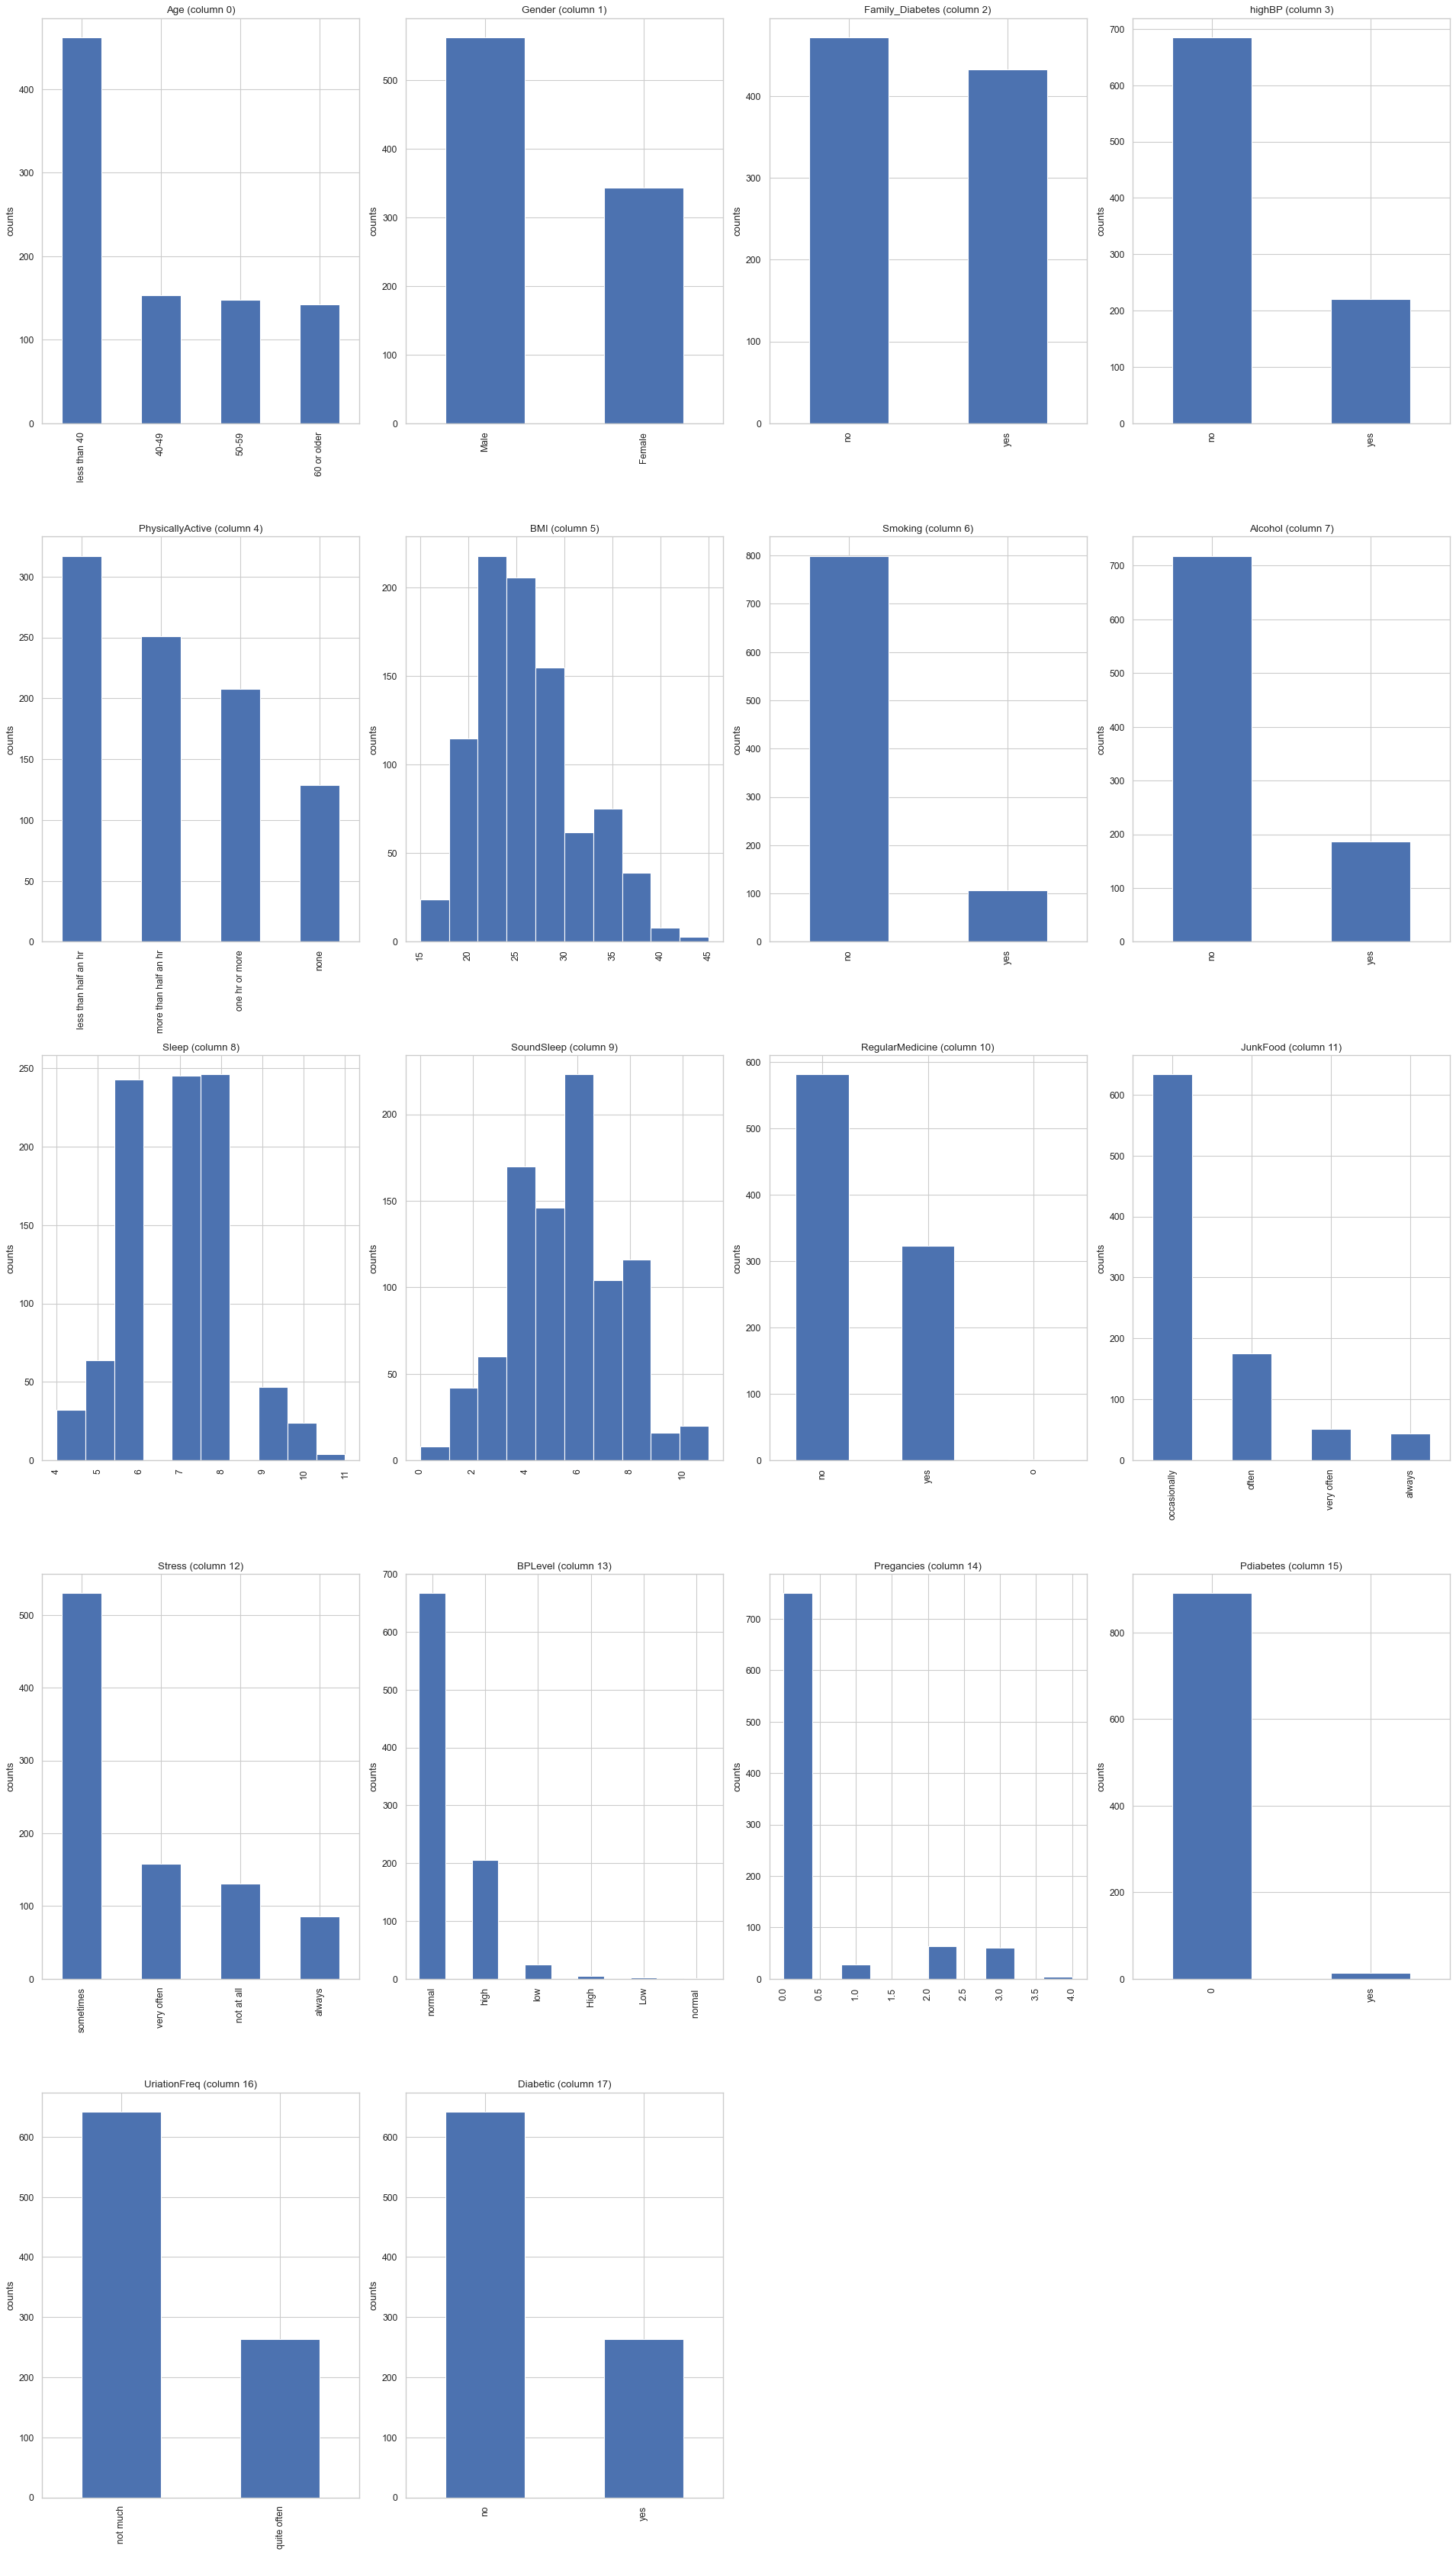

In [67]:
sns.set(style='whitegrid')
plotDistributions(df, 18, 4)

We can see the data distribution for all of our features. Specifically, we recognize: 
- Age: There are much more people under 40. Other groups (40-49, 50-59, 60 or older) are quite balanced. 
- Gender: More male than female participants (around 550 to 330).
- Family_Diabetes: 'no' to 'yes' almost balanced.
- A lot of unbalanced features: highBP, Smoking, Alcohol, Pdiabetes and so on. 
- RegularMedicine: Incorrect recording 'o' instead of 'no'. Will be changed to 'no' since we see in the paper that we should only have yes/no and the 'n' was clearly missing.
- BPLevel: Incorrect recordings due to misspellings ('normal'-'normal ', 'low'-'Low', 'high'-'High')
- Pdiabetes: Incorrect recording '0' instead of 'no'.
- **Diabetic (target variable)**: We clearly have an unbalanced dataset for our target variable 'Diabetic'. Because of that we should think about **balancing our dataset**.

In [89]:
# update column 'RegularMedicine'
df.loc[df['RegularMedicine']=='o', 'RegularMedicine'] = 'no'

# update column 'BPLevel'
df.loc[df['BPLevel']=='normal ', 'BPLevel'] = 'normal'
df.loc[df['BPLevel']=='Low', 'BPLevel'] = 'low'
df.loc[df['BPLevel']=='High', 'BPLevel'] = 'high'

# update column 'Pdiabetes'
df.loc[df['Pdiabetes']=='0', 'Pdiabetes'] = 'no'

# 3) Balancing 
Since we do not have so many entries, we perform oversampling of the data. 
<font color='red'>If we find our models to perform badly we will change this choice afterwards and run again.</font> 

In [138]:
# seperate data from target
y = df['Diabetic']
X = df.drop('Diabetic', axis=1)

# oversample data
ros = RandomOverSampler(random_state=0)
X_ros, y_ros = ros.fit_resample(X, y)

In [139]:
# combine data again for further work
df_ros = pd.concat([X_ros, y_ros], axis=1)

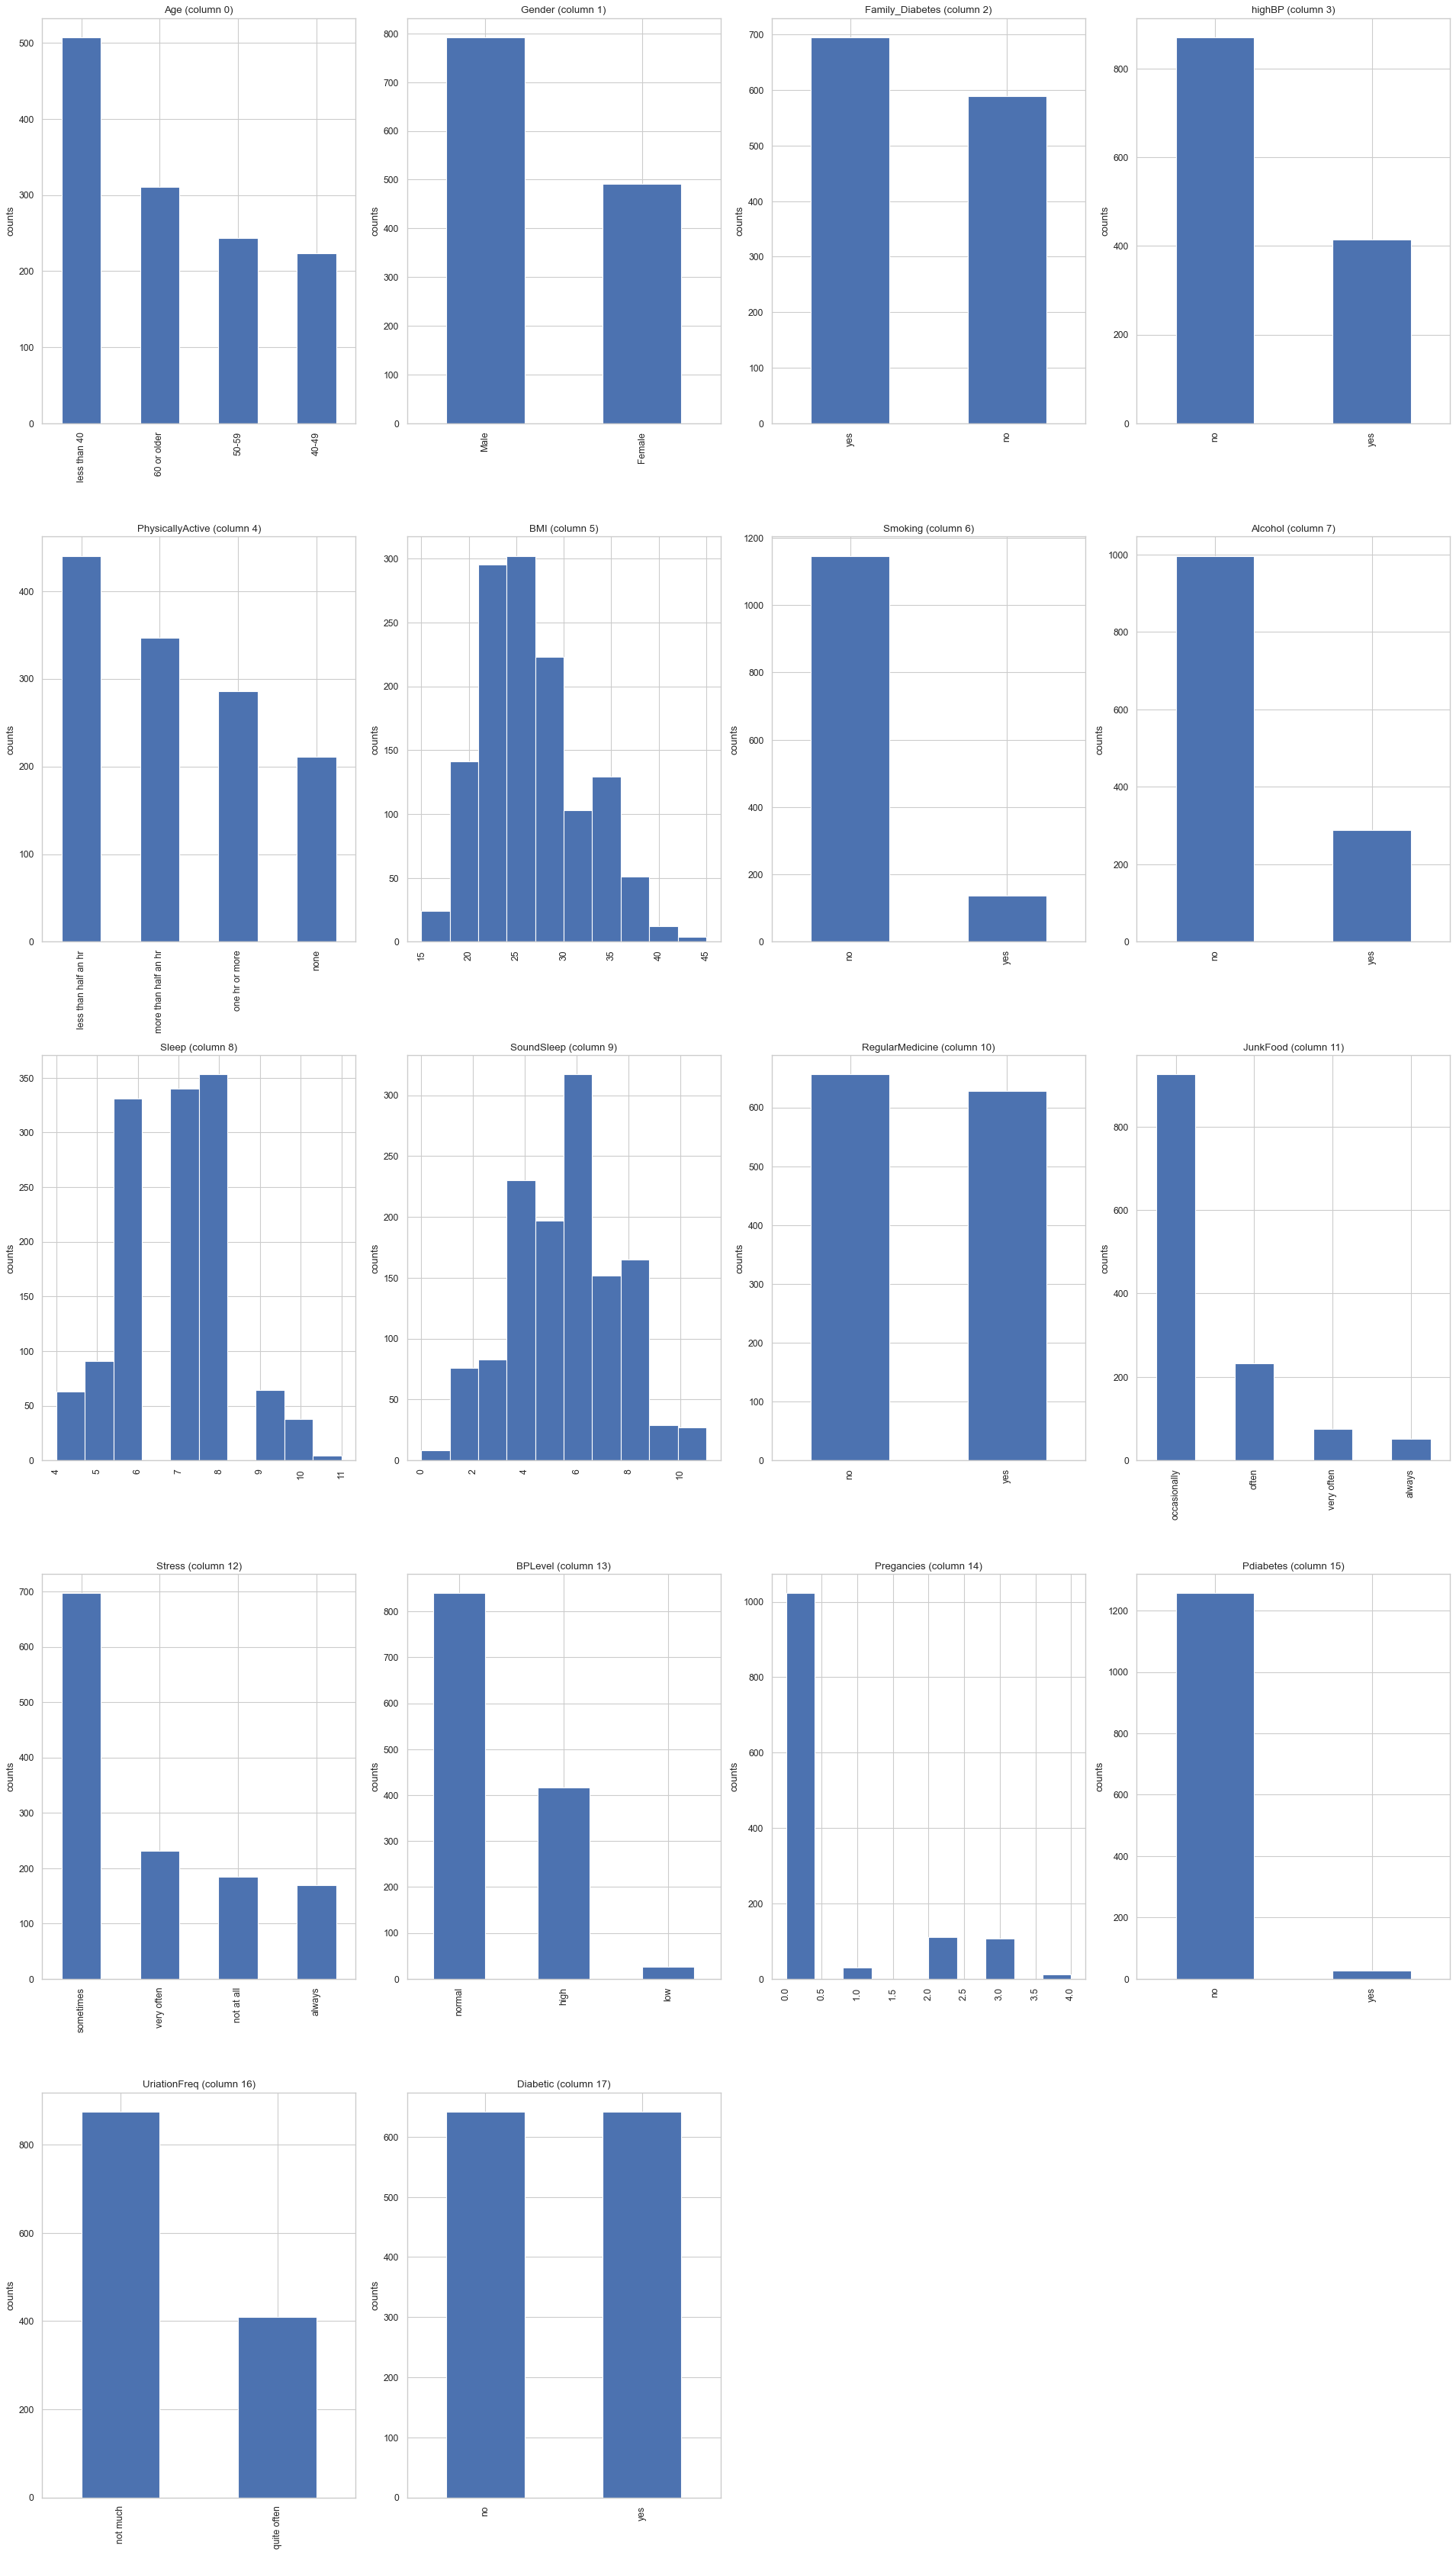

In [121]:
# plot new distributions
plotDistributions(df_ros, 18, 4)

We can see that the oversampling worked well. Let's look at the resulting number of entries after the sampling.

In [122]:
# print main information about data
print("There are {} entries with {} columns including the target variable 'Diabetic'.".format(df_ros.shape[0], df_ros.shape[1]))

There are 1284 entries with 18 columns including the target variable 'Diabetic'.


# 4) Actual Feature Engineering
After balancing, we can now engineer our features such that we can work better with our data in the models. Categorical features will be one-hot-encoded dropping one column if it is a binary column (since otherwise one column would be unnecessary). Numerical features shall be scaled with StandardScaler. 
<font color='red'>Oridnal features: Age, PhysicallyActive, JunkFood, Stress, BPLevel?</font> 
<font color='red'>Scaler used for whole data or do we have to split before?</font> 

In [123]:
# define numerical and categorical features
numerical = ['BMI', 'Sleep', 'SoundSleep', 'Pregancies']
categorical = list(set(df_header) - set(['Diabetic']) - set(numerical))

# encode the target variable into a numeric value
label_enc = preprocessing.LabelEncoder()
y_prep = label_enc.fit_transform(y_ros)

# one-hot-encoding for categorical features
onehot_enc = preprocessing.OneHotEncoder(drop='if_binary')
onehot_encoded = pd.DataFrame(onehot_enc.fit_transform(df_ros[categorical]).toarray(), 
                              columns=onehot_enc.get_feature_names(categorical))

# remove categorical features and add the one-hot encoded features to the dataframe
df_preprocessed = X_ros.drop(columns=categorical)
df_preprocessed = pd.concat([df_preprocessed, encoded], axis=1)
df_preprocessed.head()

,BMI,Sleep,SoundSleep,Pregancies,PhysicallyActive_less than half an hr,PhysicallyActive_more than half an hr,PhysicallyActive_none,PhysicallyActive_one hr or more,highBP_yes,JunkFood_always,...,Stress_always,Stress_not at all,Stress_sometimes,Stress_very often,RegularMedicine_yes,Smoking_yes,BPLevel_high,BPLevel_low,BPLevel_normal,Family_Diabetes_yes
0,39.0,8,6,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,28.0,8,6,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,24.0,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,23.0,8,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,27.0,8,8,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [125]:
df_preprocessed

,BMI,Sleep,SoundSleep,Pregancies,PhysicallyActive_less than half an hr,PhysicallyActive_more than half an hr,PhysicallyActive_none,PhysicallyActive_one hr or more,highBP_yes,JunkFood_always,...,Stress_always,Stress_not at all,Stress_sometimes,Stress_very often,RegularMedicine_yes,Smoking_yes,BPLevel_high,BPLevel_low,BPLevel_normal,Family_Diabetes_yes
0,39.0,8,6,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,28.0,8,6,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,24.0,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,23.0,8,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,27.0,8,8,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1279,27.0,6,5,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1280,26.0,6,6,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1281,28.0,8,6,2.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
1282,28.0,6,3,2.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [141]:
X_prep

,Age,Gender,Family_Diabetes,highBP,PhysicallyActive,BMI,Smoking,Alcohol,Sleep,SoundSleep,RegularMedicine,JunkFood,Stress,BPLevel,Pregancies,Pdiabetes,UriationFreq
0,50-59,Male,no,yes,one hr or more,39.0,no,no,8,6,no,occasionally,sometimes,high,0.0,no,not much
1,50-59,Male,no,yes,less than half an hr,28.0,no,no,8,6,yes,very often,sometimes,normal,0.0,no,not much
2,40-49,Male,no,no,one hr or more,24.0,no,no,6,6,no,occasionally,sometimes,normal,0.0,no,not much
3,50-59,Male,no,no,one hr or more,23.0,no,no,8,6,no,occasionally,sometimes,normal,0.0,no,not much
4,40-49,Male,no,no,less than half an hr,27.0,no,no,8,8,no,occasionally,sometimes,normal,0.0,no,not much
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1279,60 or older,Male,yes,yes,more than half an hr,27.0,no,no,6,5,yes,occasionally,sometimes,high,0.0,no,quite often
1280,60 or older,Male,yes,yes,less than half an hr,26.0,no,yes,6,6,yes,occasionally,not at all,high,0.0,no,not much
1281,40-49,Female,yes,no,more than half an hr,28.0,no,no,8,6,yes,occasionally,always,normal,2.0,no,not much
1282,50-59,Female,yes,yes,none,28.0,no,no,6,3,yes,occasionally,always,high,2.0,no,not much


In [142]:
# define numerical, ordinal, and categorical features
numerical = ['BMI', 'Sleep', 'SoundSleep', 'Pregancies']
ordinal = ['Age', 'PhysicallyActive', 'JunkFood', 'Stress', 'BPLevel']
categorical = list(set(df_header) - set(['Diabetic']) - set(numerical) - set(ordinal))

# copy dataframe
X_prep = X_ros.copy()

# encode the target variable into a numeric value
label_enc = preprocessing.LabelEncoder()
y_prep = label_enc.fit_transform(y_ros)

# encode categorical features with OneHotEncoder
onehot_enc = preprocessing.OneHotEncoder(drop='if_binary')
onehot_encoded = pd.DataFrame(onehot_enc.fit_transform(X_prep[categorical]).toarray(), 
                              columns=onehot_enc.get_feature_names(categorical))
X_prep.drop(columns=categorical, inplace=True)
X_prep = pd.concat([X_prep, onehot_encoded], axis=1)

# encode ordinal features with OrdinalEncoder
ordinal_enc = preprocessing.OrdinalEncoder()
X_prep[ordinal] = ordinal_enc.fit_transform(X_prep[ordinal])

# scale numerical features with StandardScaler
scaler = preprocessing.StandardScaler()
X_prep[numerical] = scaler.fit_transform(X_prep[numerical])

# remove categorical features and add the one-hot encoded features to the dataframe
X_prep

,Age,PhysicallyActive,BMI,Sleep,SoundSleep,JunkFood,Stress,BPLevel,Pregancies,highBP_yes,Gender_Male,UriationFreq_quite often,Alcohol_yes,RegularMedicine_yes,Smoking_yes,Pdiabetes_yes,Family_Diabetes_yes
0,1.0,3.0,2.485877,0.805294,0.235535,1.0,2.0,0.0,-0.476208,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.394720,0.805294,0.235535,3.0,2.0,2.0,-0.476208,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,3.0,-0.365701,-0.698703,0.235535,1.0,2.0,2.0,-0.476208,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,3.0,-0.555806,0.805294,0.235535,1.0,2.0,2.0,-0.476208,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.204615,0.805294,1.291125,1.0,2.0,2.0,-0.476208,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1279,2.0,1.0,0.204615,-0.698703,-0.292260,1.0,2.0,0.0,-0.476208,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
1280,2.0,0.0,0.014510,-0.698703,0.235535,1.0,1.0,0.0,-0.476208,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
1281,0.0,1.0,0.394720,0.805294,0.235535,1.0,0.0,2.0,1.489871,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1282,1.0,2.0,0.394720,-0.698703,-1.347851,1.0,0.0,0.0,1.489871,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


# 5) Feature Correlation
After preprocessing the data, we want to have a look at their inter-correlations and especially inspect the correlation of features with regards to the target variable 'Diabetic'.

In [143]:
df_prep = pd.concat([X_prep, pd.DataFrame(y_prep, columns=['Diabetic'])], axis=1)

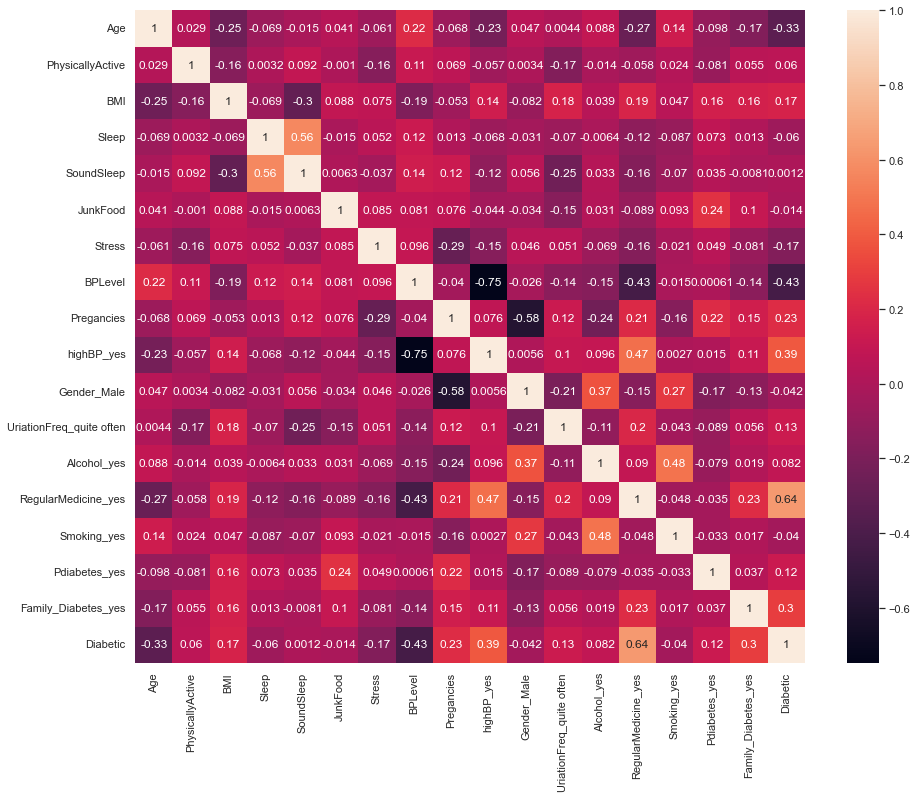

In [146]:
# look at the correlation of the data
plt.figure(figsize=(15,12))
sns.heatmap(df_prep.corr(), annot=True)
plt.show()

Next steps: 
- Analyze correlations
- Drop features?
- feature creation
- train test split